In [92]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelextrema, find_peaks, peak_widths
from statsmodels.robust import mad

# Include the utils functions
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
from utils import *

boxcar_window_size = 1001
matched_filter_window_length = (1000./3600)
matched_filter_depth = 1./np.pi
matched_filter_fwhm = 5./3600
detection_threshold = 3.
matched_filter_num_fwhm = 10

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

In [68]:
def boxcar_filter(data, boxcar_window_size):
    filt = savgol_filter(data, boxcar_window_size, 0, mode='nearest')
    filtered_data = (data - filt)
    st = moving_std(data, boxcar_window_size, mode='same')

    return filtered_data, st

def apply_lorentzian_matched_filter(time, filtered_data, st, lorentzian_fwhm, lorentzian_depth, boxcar_window_size, 
                                    delta_t=None):
    
    if(delta_t is None):
        delta_t = np.max(time[1:] - time[0:-1])
            
    lorentzian_time = np.arange(-3.*lorentzian_fwhm, 3.*lorentzian_fwhm, delta_t)
    lorentzian = modified_lorentzian(lorentzian_time, 0., 0., 0., lorentzian_depth, lorentzian_fwhm)

    convolution = np.convolve(filtered_data/st, lorentzian, mode='same')
    convolution -= np.median(convolution)
    convolution /= mad(convolution)

    med = np.median(convolution)
    md = mad(convolution)
    
    return convolution, med, md

def find_vortices(time, convolution, detection_threshold=3):
    """Finds outliers """
    
    med = np.median(convolution)
    md = mad(convolution)
    
    ind = convolution >= (med + detection_threshold*md)
    ex = find_peaks(convolution[ind])

    
    pk_wds, _, _, _ = peak_widths(convolution[ind], ex[0])
    
    return np.searchsorted(time, time[ind][ex[0]]), pk_wds

/Users/bjackson/research/Active Projects/Recovering-Martian-Dust-Devil-Population/code/utils.py:178: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)


10.7782799803367


Text(0, 0.5, '$\\Delta P\\,\\left( {\\rm Pa} \\right)$')

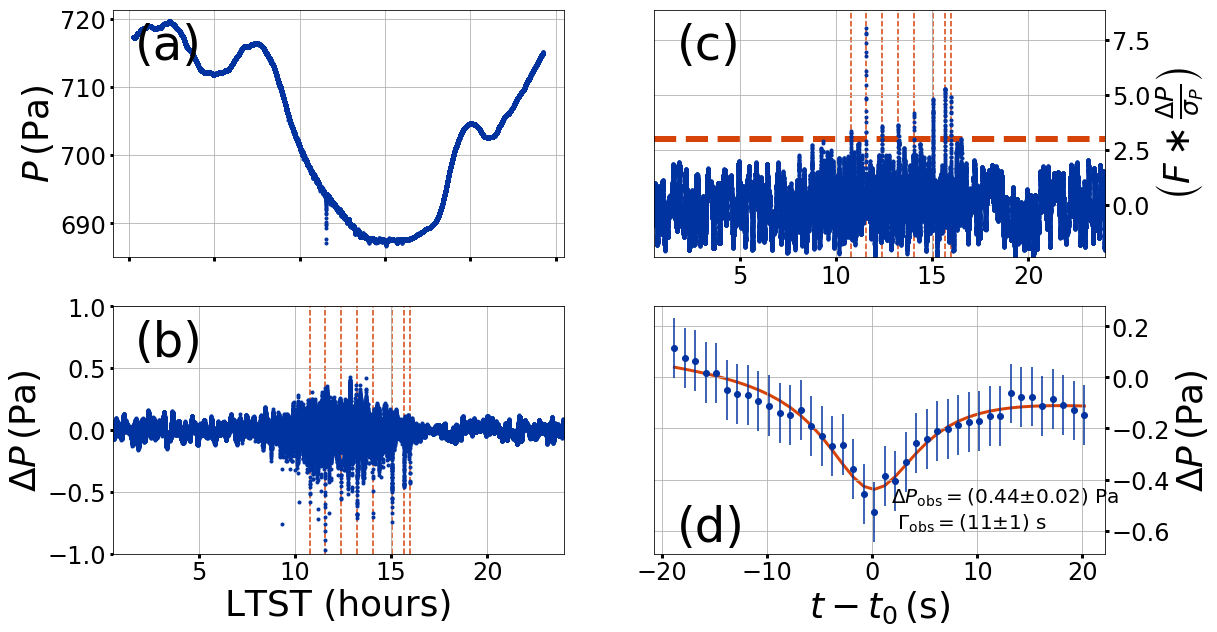

In [93]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
sol = 323

LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol, dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated")
LTST_and_sol -= 24.*sol
    
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])

fig = plt.figure(figsize=(10*aspect_ratio, 10))

### Raw Data ###

ind = (LTST_and_sol > np.min(LTST_and_sol) + boxcar_window_size*delta_t) &\
        (LTST_and_sol < np.max(LTST_and_sol) - boxcar_window_size*delta_t)

ax1 = fig.add_subplot(221)
ax1.plot(LTST_and_sol, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)
ax1.text(0.05, 0.8, "(a)", fontsize=48, transform=ax1.transAxes)
ax1.grid(True)
ax1.tick_params(labelsize=24, labelbottom=False)
ax1.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)

### Filtered Data ###

# ax2 = fig.add_subplot(223, sharex=ax1)
ax2 = fig.add_subplot(223)

filtered_pressure, st = boxcar_filter(sol_data['PRESSURE'], boxcar_window_size)

ax2.plot(LTST_and_sol, filtered_pressure, marker='.', ls='', color=BoiseState_blue)
ax2.text(0.05, 0.8, "(b)", fontsize=48, transform=ax2.transAxes)
ax2.grid(True)
ax2.tick_params(labelsize=24)
ax2.set_xlabel("LTST (hours)", fontsize=36)
ax2.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

ax2.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
# ax2.set_ylim([0.9*np.min(filtered_pressure[ind]), 1.1*np.max(filtered_pressure[ind])])
ax2.set_ylim([-1, 1])

### Matched Filter ###

# Convolve with Lorentzian

convolution, med, md = apply_lorentzian_matched_filter(LTST_and_sol, filtered_pressure, st, 
                                                      matched_filter_fwhm, matched_filter_depth, boxcar_window_size)

ax3 = fig.add_subplot(222)
ax3.plot(LTST_and_sol, convolution, color=BoiseState_blue, ls='', marker='.')
ax3.axhline(med + detection_threshold*md, color=BoiseState_orange, ls='--', lw=6, zorder=-1)
ax3.text(0.05, 0.8, "(c)", fontsize=48, transform=ax3.transAxes)
ax3.grid(True)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize=24, labelleft=False, labelright=True)

ax3.set_ylabel(r'$\left( F \ast \frac{\Delta P}{\sigma_P} \right)$', fontsize=36)
# ax3.set_xlabel("LTST (hours)", fontsize=36)
ax3.set_xlim([np.min(LTST_and_sol[ind]), np.max(LTST_and_sol[ind])])
ax3.set_ylim([0.9*np.min(convolution[ind]), 1.1*np.max(convolution[ind])])

### Fit Vortex ###
ax4 = fig.add_subplot(224)

ex, pk_wds = find_vortices(LTST_and_sol, convolution, detection_threshold=detection_threshold)
for cur_ex in ex:
    ax2.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    ax3.axvline(LTST_and_sol[cur_ex], color=BoiseState_orange, zorder=-1, ls='--')
    
# Take largest one
# mx_ind = np.argmax(convolution[ex])
mx_ind = np.argmin(convolution[ex])
# mx_ind = np.argmin(np.abs(convolution[ex] - np.median(convolution[ex])))
# mx_ind = 7
mx_width = int(pk_wds[mx_ind])

# Use original, unfiltered data
vortex = np.array([LTST_and_sol[ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                ex[mx_ind] + matched_filter_num_fwhm*mx_width], 
                   sol_data['PRESSURE'][ex[mx_ind] - matched_filter_num_fwhm*mx_width:
                                        ex[mx_ind] + matched_filter_num_fwhm*mx_width]])

errs = st[ex[mx_ind] - matched_filter_num_fwhm*mx_width: ex[mx_ind] + matched_filter_num_fwhm*mx_width]

init_params = determine_init_params(vortex)
bounds = determine_bounds(vortex, init_params)

popt, uncertainties = fit_vortex(vortex, init_params, bounds, rescale_uncertainties=True, zoomed_in=None)
print(popt[2])

ax4.errorbar((vortex[0] - popt[2])*3600, vortex[1] - popt[0], yerr=errs, ls='', marker='o', color=BoiseState_blue)
ax4.plot((vortex[0] - popt[2])*3600, modified_lorentzian(vortex[0], *popt) - popt[0], 
         lw=3, color=BoiseState_orange, zorder=-1)

ax4.text(0.05, 0.05, "(d)", fontsize=48, transform=ax4.transAxes)
ax4.text(0.525, 0.1, ("$\\Delta P_{\\rm obs} = $(%.2g$\\pm$%.1g) Pa \n $\\Gamma_{\\rm obs} = $(%.2g$\\pm$%.1g) s" %\
                       (popt[3], uncertainties[3], popt[4]*3600, uncertainties[4]*3600)), 
         fontsize=20, transform=ax4.transAxes)
ax4.grid(True)
ax4.yaxis.set_label_position("right")
ax4.yaxis.tick_right()
ax4.tick_params(labelsize=24, labelleft=False, labelright=True)
ax4.set_xlabel(r'$t - t_0\,\left( {\rm s} \right)$', fontsize=36)
ax4.set_ylabel(r'$\Delta P\,\left( {\rm Pa} \right)$', fontsize=36)

# fig.savefig("../figures/data_conditioning_and_fit.png", dpi=500, bbox_inches='tight')

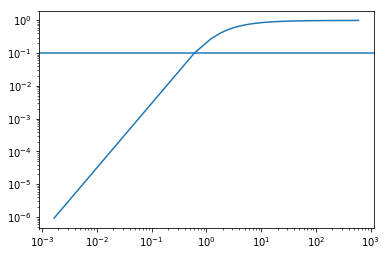

In [2]:
# W/Gamma
x = np.linspace(0.5/300, 300/0.5, 1000)
f = 1. - np.arctan(x)/x

plt.loglog(x, f)
plt.axhline(0.1)

/Users/brian/Documents/research/Recovering-Martian-Dust-Devil-Population/code/utils.py:178: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)


0.009624157525779962


/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if sys.path[0] == '':


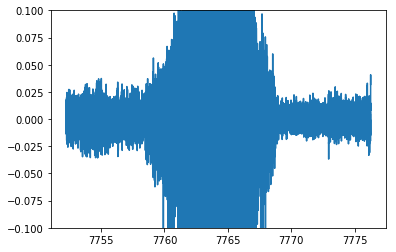

In [4]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol)

pressure_filter = savgol_filter(sol_data['PRESSURE'], 101, 0, mode='nearest')
plt.plot(LTST_and_sol, sol_data['PRESSURE'] - pressure_filter)
plt.ylim([-0.1, 0.1])
print(np.median(moving_std(sol_data['PRESSURE'] - pressure_filter, 101, mode='same')))

filename = "../Previous Studies/Data from Spiga et al. 2020/alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)
ind = Spigas_data["SOL"] == sol
Spigas_data_sol = Spigas_data[ind]

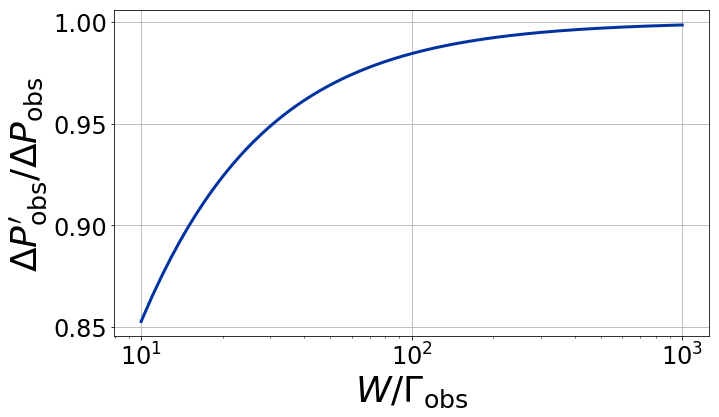

In [13]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(111)
# plt.setp(ax2.get_yticklabels(), visible=False)

# This calculation reflects the change in Delta P from the Savitsky-Golay filter

x = np.linspace(10, 1000, 1000)
f = 1. - np.arctan(x)/x
ax1.semilogx(x, f, color=BoiseState_blue, lw=3)
# plt.axhline(0.1)
# print(x[np.argmin(np.abs(f - 0.1))])
# print(f[np.argmin(np.abs(x - 100.))])

delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
min_window_size = 2./3600
max_window_size = 1000./3600
window_lengths = np.arange(10*int(min_window_size/delta_t) + 1, int(max_window_size/delta_t), 2)

# stds = np.array([])
# for i in range(len(window_lengths)):
#     pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths[i], 0, mode='nearest')
#     stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
    
ax1.set_xlabel(r'$W/\Gamma_{\rm obs}$', fontsize=36)
ax1.set_ylabel(r'$\Delta P_{\rm obs}^\prime/\Delta P_{\rm obs}$', fontsize=36)

ax1.grid(True)

ax1.tick_params(labelsize=24)

fig.savefig("")

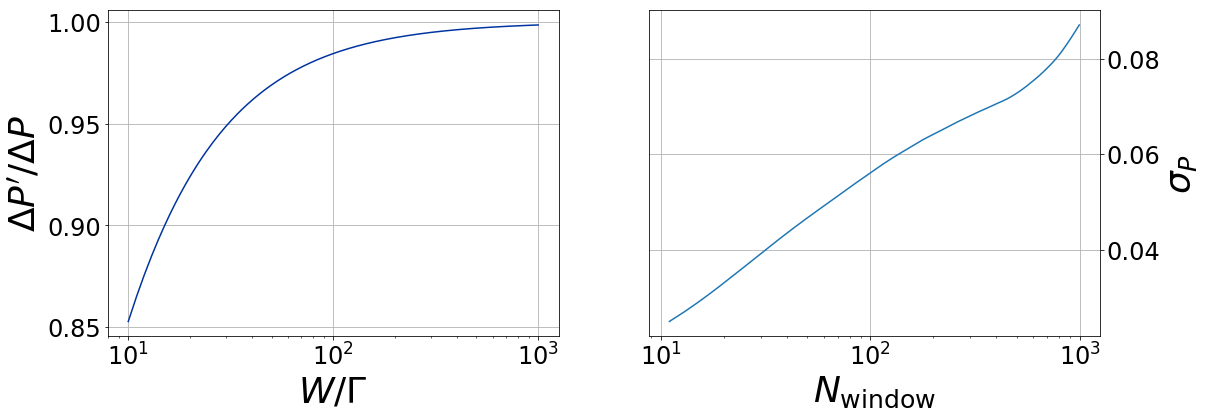

In [15]:
fig = plt.figure(figsize=(10*aspect_ratio, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# plt.setp(ax2.get_yticklabels(), visible=False)

# This calculation reflects the change in Delta P from the Savitsky-Golay filter

x = np.linspace(10, 1000, 1000)
f = 1. - np.arctan(x)/x
ax1.semilogx(x, f, color=BoiseState_blue)
# plt.axhline(0.1)
# print(x[np.argmin(np.abs(f - 0.1))])
# print(f[np.argmin(np.abs(x - 100.))])

delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
min_window_size = 2./3600
max_window_size = 1000./3600
window_lengths = np.arange(10*int(min_window_size/delta_t) + 1, int(max_window_size/delta_t), 2)

stds = np.array([])
for i in range(len(window_lengths)):
    pressure_filter = savgol_filter(sol_data['PRESSURE'], window_lengths[i], 0, mode='nearest')
    stds = np.append(stds, np.std(sol_data['PRESSURE'] - pressure_filter))
    
ax2.semilogx(window_lengths, stds)

ax1.set_xlabel(r'$W/\Gamma$', fontsize=36)
ax1.set_ylabel(r'$\Delta P^\prime/\Delta P$', fontsize=36)

ax2.set_xlabel(r'$N_{\rm window}$', fontsize=36)
ax2.set_ylabel(r'$\sigma_P$', fontsize=36)
ax2.yaxis.set_label_position("right")

ax1.grid(True)
ax2.grid(True)

ax1.tick_params(labelsize=24)
ax2.tick_params(labelsize=24, labelleft=False, labelright=True)
ax2.yaxis.tick_right()

# plt.ylim([1e-2, 1])

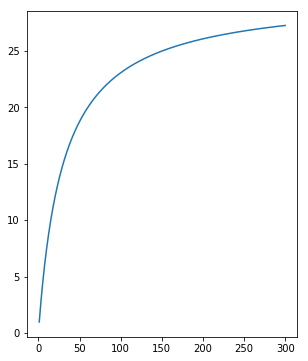

In [31]:
fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax1 = fig.add_subplot(121)
# plt.setp(ax2.get_yticklabels(), visible=False)

Gamma = 30. # seconds
Gamma_prime = np.linspace(1., 300., 1000)
f = Gamma*Gamma_prime/(Gamma + Gamma_prime)

plt.plot(Gamma_prime, f)

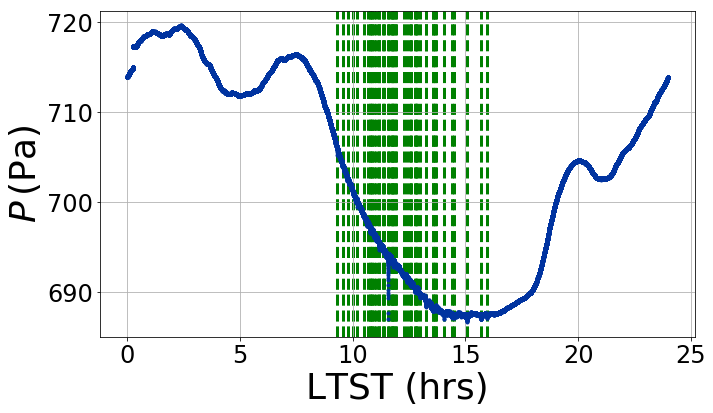

In [3]:
# dt = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
# edges = bayesian_blocks(LTST_and_sol, sol_data['PRESSURE'], fitness='measures')

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

ax.plot(LTST, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)

for cur_vortex in Spigas_data_sol['_LTST_']:
    ax.axvline(cur_vortex, color='green', ls='--', lw=3, zorder=-1)

    ax.tick_params(labelsize=24)
ax.set_xlabel("LTST (hrs)", fontsize=36)
ax.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)
ax.grid(True)

(7760, 7770)

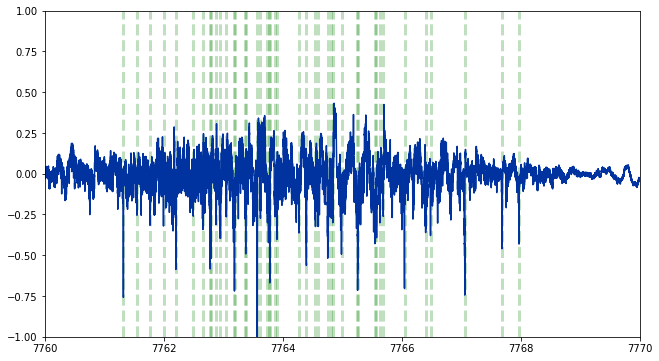

In [11]:
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)

# High-pass filter the pressure data
men = moving_average(sol_data['PRESSURE'], window_length, mode='same')
st = moving_std(sol_data['PRESSURE'], window_length, mode='same')
# filtered_pressure = (sol_data['PRESSURE'] - men)#/st
# print(np.median(st[(LTST_and_sol > 1569) & (LTST_and_sol < 1576)]))
# print(np.std(filtered_pressure[(LTST_and_sol > 1569) & (LTST_and_sol < 1576)]))
# print(mad(filtered_pressure[(LTST_and_sol > 1569) & (LTST_and_sol < 1576)]))

pressure_filter = savgol_filter(sol_data['PRESSURE'], window_length, 0, mode='nearest')
filtered_pressure = sol_data['PRESSURE'] - pressure_filter
# filtered_pressure /= mad(filtered_pressure)

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# ax.plot(LTST_and_sol, st, color=BoiseState_blue)
ax.plot(LTST_and_sol, filtered_pressure, color=BoiseState_blue)
# ax.axhline(np.median(filtered_pressure) - 5.*mad(filtered_pressure))
# ax.axhline(np.median(filtered_pressure) + 5.*mad(filtered_pressure))

ax.axhline(-5.)
# ax.axhline(3.)

# ax.axhline(3.)

# edges = bayesian_blocks(LTST_and_sol, filtered_pressure, 3., fitness='measures', ncp_prior=3.)
# edges = bayesian_blocks(LTST_and_sol, filtered_pressure, mad(filtered_pressure), fitness='measures')

# for cur_edge in edges:# - 24.*sol:
#     ax.axvline(cur_edge, color=BoiseState_orange, zorder=-1)
    
for cur_vortex in Spigas_data_sol['_LTST_'] + 24.*sol:
    ax.axvline(cur_vortex, color='green', ls='--', lw=3, zorder=-1, alpha=0.25)

# ax.set_ylim([0, 1])
# ax.set_ylim([0, 0.1])
    
ax.set_ylim([-1, 1])
# ax.set_xlim([1569, 1576])
ax.set_xlim([7760, 7770])
# ax.set_xlim([1571.5, 1572.5])
# ax.set_xlim([1574.6, 1574.8])
# ax.set_xlim([9.5, 16])
# ax.set_ylim([-10, 10])

(317,)


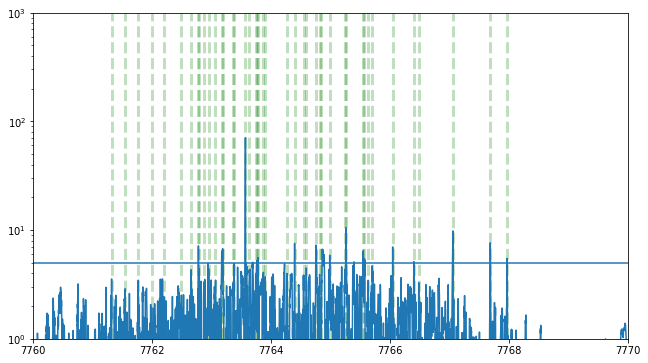

In [13]:
# Convolve with Lorentzian
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)

depth = 1. # Pa
width = 5.*delta_t # seconds
lorentzian_time = np.arange(-3.*width, 3.*width, delta_t)
lorentzian = modified_lorentzian(lorentzian_time, 0., 0., 0., depth, width)
lorentzian /= np.abs(np.min(lorentzian))

# High-pass filter the pressure data
men = moving_average(sol_data['PRESSURE'], window_length, mode='same')
st = moving_std(sol_data['PRESSURE'], window_length, mode='same')
filtered_pressure = (sol_data['PRESSURE'] - men)#/st

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

convolution = np.convolve(filtered_pressure, lorentzian, mode='same')
convolution -= np.median(convolution)
convolution /= mad(convolution)
# ax.plot(LTST_and_sol, filtered_pressure)
ax.semilogy(LTST_and_sol, np.abs(convolution))

ax.set_xlim([7760, 7770])
ax.set_ylim([1, 1000])

# ax.plot(LTST_and_sol, st, color=BoiseState_blue)
    
# Retreive convolution values    
convolve_values = np.zeros_like(Spigas_data_sol['_LTST_'])
for i in range(len(Spigas_data_sol['_LTST_'])):
    ax.axvline(Spigas_data_sol['_LTST_'][i] + 24.*sol, color='green', ls='--', lw=3, zorder=-1, alpha=0.25)
    convolve_values[i] = convolution[np.argmin(np.abs(Spigas_data_sol['_LTST_'][i] + 24.*sol - LTST_and_sol))]
    
ax.axhline(5.)

print(convolution[convolution > 5].shape)

(1650,)


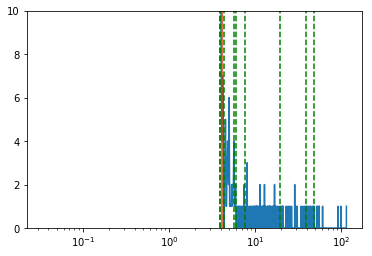

In [79]:
ind = (LTST_and_sol > 1569) & (LTST_and_sol < 1576)

hst, bin_edges = np.histogram(np.abs(convolution[ind]), bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])

plt.semilogx(bins, hst)
med = np.median(np.abs(convolution[ind]))
md = mad(np.abs(convolution[ind]))

plt.axvline(med + 5.*md, color=BoiseState_orange)
plt.axvline(med - 5.*md, color=BoiseState_orange)

for val in convolve_values:
    plt.axvline(val, color='green', ls='--')
    
# plt.xlim([3, 100])
plt.ylim([0, 10])

print(hst[bins > med + 5.*md].shape)